## Header 
Author : Amina Matt and Yichen Wang  
Date created : 14.10.2021  
Date last modified : 21.11.2021  
Python version : 3.8  
Description : Text processing of the CARICOM Compilation Archive (CCA) https://louverture.ch/cca/ 



# To Do List
- [X] check number items
- [X] to JSON 
- [X] JSON fix None answer
- [ ] Add colonial location
- [ ] JSON cleaning of parenthesis in names?
- [ ] save NER 

# Initialization

In [1]:
# -*- coding: utf-8 -*-

import nltk #Natural Language Toolkit is a natural language programming library
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import pandas as pd
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree
from nltk.tree import Tree
import random
from pandas.io.json import json_normalize


#PATHS
DATA_FOLDER = './data/'
caricom_sample = DATA_FOLDER +'Caricom_Archive_Sample_Schema1.txt'
caricom = DATA_FOLDER +'Caricom_Archive.txt'

# Text separation into items 
In the primary text source, each item is separated by a return and the '=>' starting string. Each item references a different actor of colonial entreprise. Separating each of them into items helps us to differentiate the extraction depending on the scheme they follow.

In [2]:
#Input: path for the .txt file 
#Output: list of string, where each element is an item, i.e. a separate entry in the document of origin
#Requirements: -
#Description: separate the items based on the '=>' string that characterize a new entry
def divide_items(textFilePath):
    f = open(textFilePath,"r")
    item = []
    flagTOC = False
    for line in f: 
        
        if (line == '1 CARICOM MEMBER STATES\n') :
            flagTOC = True #the TOC has been fully read
            print('the TOC has been read')
            
        if flagTOC : #check if line is a TOC entry
            if (line[0].isdigit()) and  (line[1] == '.') and (line[2].isdigit()) : #we have a subTOC entry, level n.n
                colonialIndex = line[0:3]
                colonialIndex = colonialIndex.replace('\n','')
                print('the colonial index is ' + str(colonialIndex))
              
        if (line != '\n'):
            if (line[0] == '=') and (line[1] == '>'):
                item_text = ''
                while (line != '\n'):
                    item_text = item_text + line
                    line = f.readline()
                #Once the item is read we add its colonial index that corresponds to a TOC entry
                #We add the index at the end to retrieve it easily
                item_text = item_text.replace('\n','') 
                print(item_text)
                item_text = item_text + (' '+colonialIndex)
                #print('The text item now has the colonial index'+item_text)
                item.append(item_text)
    f.close()
    return item 

In [3]:
text_items = divide_items(caricom)
items_total = len(text_items)
print(f'There are {len(text_items)} items in total.')

the TOC has been read
the colonial index is 1.1
=> Arthur Thellusson, son of Lord Rendlesham and grandson of Peter Thellusson, born into a Geneva banking family, who had bought the original Brodsworth Hall estate in South Yorkshire (GB) in 1790, married the daughter of Antigua slave owner Sir Christopher Bethell-Codrington.
=> In her book A Small Place (1988), the Antiguan writer Jamaica Kincaid indicts the Antiguan government, the tourist industry and Antigua’s British colonial legacy by saying:
=> Hans Conrad Hottinger (Hottinguer) (1764–1841) from Zurich started in the textile (indiennes) business in Mulhouse, then went into banking, learning his trade with Passavant and de Candolle in Geneva. During the «terror» of the French Revolution, he left Paris for the USA, where he stayed for three years. In 1793, he married Martha Eliza Redwood (1774–1830) from Newport (Rhode Island) and was thus related to a family which had been in the sugar and plantation business between England, New E

In [4]:
text_items = divide_items(caricom)

the TOC has been read
the colonial index is 1.1
=> Arthur Thellusson, son of Lord Rendlesham and grandson of Peter Thellusson, born into a Geneva banking family, who had bought the original Brodsworth Hall estate in South Yorkshire (GB) in 1790, married the daughter of Antigua slave owner Sir Christopher Bethell-Codrington.
=> In her book A Small Place (1988), the Antiguan writer Jamaica Kincaid indicts the Antiguan government, the tourist industry and Antigua’s British colonial legacy by saying:
=> Hans Conrad Hottinger (Hottinguer) (1764–1841) from Zurich started in the textile (indiennes) business in Mulhouse, then went into banking, learning his trade with Passavant and de Candolle in Geneva. During the «terror» of the French Revolution, he left Paris for the USA, where he stayed for three years. In 1793, he married Martha Eliza Redwood (1774–1830) from Newport (Rhode Island) and was thus related to a family which had been in the sugar and plantation business between England, New E

In [5]:
print(f'This is one text item:\n{text_items[random.randrange(len(text_items))]}.\n')

This is one text item:
=> Maria Sibylla Merian (1647-1717), from the original Bâle branch of her family, left a few critical remarks on slavery during her stay in Suriname (1699-1701) in her work Metamorphosis insectorum Surinamensium. However, she never questioned slavery as such, and used indigenous and African slaves for her research and expeditions. She herself enslaved an indigenous woman during her voyage back to Holland in order to obtain first-hand botanical information. The details of this indigenous woman’s life beyond her servile captivity on the journey to Amsterdam were not documented by Merian and are therefore unknown. 1.1.



## Table of Contents retrieving

In [6]:
def tocList_func(textFilePath):
    f = open(textFilePath,"r")
    tocList = []
    for line in f: 
        if (line == '1 CARICOM MEMBER STATES\n') :
            break
        else : 
            if (line[0].isdigit()) and  (line[1] == '.') and (line[2].isdigit())  : #we have a subTOC entry, level n.n
                toc = (line[0:3],line[4:-1])
                #print(toc)
                tocList.append(toc)
    f.close()
    return tocList
tocList = tocList_func(caricom)   

## Named Entities Recognition with NER Stanford 
The first objective is to extract information of interest from the text. In this case we are interested in person's names, locations and activities. The first step towards this goal is to use Named Entities Recognition to recognize which words contain the information we are looking for.

In [7]:
#Stanford NER 
NER_FOLDER = './NER-Standford/stanford-ner-2020-11-17'
CLASSIFIER_PATH = NER_FOLDER+'/classifiers/'
JAR_PATH = NER_FOLDER+'/stanford-ner.jar'

#classifiers
classifier_3 = 'english.all.3class.distsim.crf.ser.gz'#3 class model for recognizing locations, persons, and organizations
classifier_4 = 'english.conll.4class.distsim.crf.ser.gz'#4 class model for recognizing locations, persons, organizations, and miscellaneous entities
classifier_7 = 'english.muc.7class.distsim.crf.ser.gz' #7 class model for recognizing locations, persons, organizations, times, money, percents, and dates

st = StanfordNERTagger(CLASSIFIER_PATH+classifier_7, JAR_PATH, encoding='utf-8')



#Extracting named-entities
text = open(caricom_sample, 'r').read()
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('=', 'O'), ('>', 'O'), ('François', 'PERSON'), ('Aimé', 'PERSON'), ('Louis', 'PERSON'), ('Dumoulin', 'PERSON'), ('(', 'O'), ('1753-1834', 'O'), (')', 'O'), ('from', 'O'), ('Vevey', 'LOCATION'), ('(', 'O'), ('Canton', 'LOCATION'), ('of', 'O'), ('BerneVaud', 'O'), (')', 'O'), ('left', 'O'), ('Switzerland', 'LOCATION'), ('at', 'O'), ('the', 'O'), ('age', 'O'), ('of', 'O'), ('20', 'O'), ('for', 'O'), ('the', 'O'), ('Caribbean', 'LOCATION'), ('and', 'O'), ('lived', 'O'), ('on', 'O'), ('Grenada', 'LOCATION'), ('1773–1783', 'O'), ('.', 'O'), ('He', 'O'), ('worked', 'O'), ('as', 'O'), ('a', 'O'), ('painter', 'O'), (',', 'O'), ('secretary', 'O'), ('to', 'O'), ('the', 'O'), ('governor', 'O'), ('of', 'O'), ('the', 'O'), ('island', 'O'), (',', 'O'), ('and', 'O'), ('merchant', 'O'), ('.', 'O'), ('In', 'O'), ('1778', 'DATE'), (',', 'O'), ('he', 'O'), ('was', 'O'), ('pressed', 'O'), ('into', 'O'), ('the', 'O'), ('English', 'O'), ('army', 'O'), ('of', 'O'), ('Governor', 'O'), ('MacCartney', 'O'), ('

At this point the whole text is tagged. However the entities aren't grouped together. For example, a person full name is separate into two tuples.

## BIO tagging for readable Named Entities (i.e. regrouped NE)

[BIO](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) tags are a way to regroup tokens, to make the output more readable. 
A person name with first and last name should be regroup by assigning  
 -B to the beginning of named entities  
 -I assigned to inside  
 -O assigned to other  
This is done by checking the tokens just before and after the one of interest.

In [8]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Tag tokens with standard NLP BIO tags
def bio_tagger(ne_tagged):
		bio_tagged = [] #empty list
		prev_tag = "O" #starting with a O tag
		for token, tag in ne_tagged:
			if tag == "O": #O
				bio_tagged.append((token, tag))
				prev_tag = tag
				continue
			if tag != "O" and prev_tag == "O": # Begin NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag == tag: # Inside NE
				bio_tagged.append((token, "I-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
		return bio_tagged

In [9]:
bio_text = bio_tagger(classified_text)
bio_text

[('=', 'O'),
 ('>', 'O'),
 ('François', 'B-PERSON'),
 ('Aimé', 'I-PERSON'),
 ('Louis', 'I-PERSON'),
 ('Dumoulin', 'I-PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'B-LOCATION'),
 ('(', 'O'),
 ('Canton', 'B-LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'B-LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'B-LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'B-LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'B-DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English',

Using the BIO tags we can recreate a tokens list with regrouped/readable named entities. 

In [10]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Create tree       
def stanford_tree(bio_tagged):
	tokens_raw, ne_tags = zip(*bio_tagged)
	tokens = [word for word in tokens_raw if word]
	pos_tags = [pos for token, pos in pos_tag(tokens)]

	conlltags = [(token, pos, ne) for token, pos, ne in zip(tokens, pos_tags, ne_tags)]
	ne_tree = conlltags2tree(conlltags) #from BIO to tree format
	return ne_tree

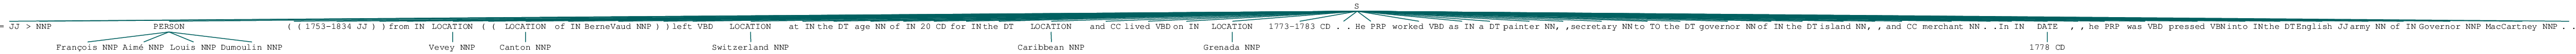

In [11]:
tree_text = stanford_tree(bio_text)
tree_text

In [12]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Parse named entities from tree
def structure_ne(ne_tree):
	ne = []
	for subtree in ne_tree:
		if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
			ne_label = subtree.label()
			ne_string = " ".join([token for token, pos in subtree.leaves()])
			ne.append((ne_string, ne_label))
		else:
			ne_label = 'O'
			ne_string = subtree[0]
			ne.append((ne_string, ne_label))           
	return ne

In [13]:
clean_ne = structure_ne(tree_text)
clean_ne

[('=', 'O'),
 ('>', 'O'),
 ('François Aimé Louis Dumoulin', 'PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'LOCATION'),
 ('(', 'O'),
 ('Canton', 'LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English', 'O'),
 ('army', 'O'),
 ('of', 'O'),
 ('Governor', 'O'),
 ('MacCartn

In [14]:
def ner_text(text):
    tokenized_text = word_tokenize(text)
    classified_text = st.tag(tokenized_text)
    bio_text = bio_tagger(classified_text)
    tree_text = stanford_tree(bio_text)
    ner_item = structure_ne(tree_text)
    return ner_item

# From NE tree to JSON

The structure NE list for each text is transformed into an entry in a dataframe. The goal is to have for each sample of text an entry with the *relevant* informations.  
The difficult part is to sort the relevant informations. Which of the persons is the one of interest? Which location is the location where the organization or the person was involved? Which dates are the dates of interest? 
Here we deal only with the transformation.

## Use schema 1 **(*name* (date) from *origin*)** to retrieve JSON names, origins and dates attributes in the text item.

In [15]:
#MIGHT BE USELESS 
#Input:
#Output: 
#Requirements: 
#Description: 
def is_date(dateString):
    return any(s.isdigit() for s in dateString)
#Works for (1731-1820)

In [16]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: True is the text is structured as schema 1, False otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. Namely, does the first words match the  **Name** (*date*) from *city* pattern.
def schema1_test(item):
    tags = [x[1] for x in item]
    text_middle= [x[0] for x in item]
    #start and end of piece of interest
    schema1 = False
    try:
        person_Index = tags.index('PERSON')
    except ValueError:
        person_Index = 1 #default
        print("List does not contain value")
    try: 
        location_Index = tags.index('LOCATION')
    except ValueError:
        print("List does not contain value")
        location_Index = 0 #default
    if person_Index < location_Index:
        ner_middle = item[person_Index+1:location_Index-1]
    #digit test
    digit_test = any(x.isdigit() for x in text_middle)
    #parenthesis test
    if digit_test :
        schema1 = ('(' and ')') in text_middle#parenthesis test

    return schema1

In [17]:
#Function test
schema1_test(ner_text(text_items[80]))

True

## Compute how many items follow the **(*name* (date) from *origin*)** schema (schema 1)

In [19]:
ner_items = []
for item in text_items:
    ner_item = ner_text(item)
    ner_items.append(ner_item)
len(ner_items)

KeyboardInterrupt: 

In [20]:
len(ner_items)

424

In [35]:
294/424

0.6933962264150944

In [ ]:
s1_items= []
i = 0
s1 = 0
for item in ner_items:
    #print(ner_item[0:8])
    #print(str(i)+'\n')
    i = i+1
    if schema1_test(item):
        s1 = s1 + 1
        print(f'Total schema1 found: {s1}')
        s1_items.append(ner_item)

In [86]:
s1_tot = len(s1_items)
print(f'With the new function we found {s1_tot} items following schema 1.\n\nOne example is : {s1_items[6]}\n')

With the new function we found 322 items following schema 1.

One example is : [('=', 'O'), ('>', 'O'), ('Johann Viktor Travers von Ortenstein ( 1721–1776 )', 'PERSON'), (',', 'O'), ('of', 'O'), ('a', 'O'), ('noble', 'O'), ('family', 'O'), ('from', 'O'), ('TumeglDomleschg', 'O'), (',', 'O'), ('entered', 'O'), ('his', 'O'), ('father', 'O'), ('’', 'O'), ('s', 'O'), ('regiment', 'O'), ('in', 'O'), ('Valenciennes', 'LOCATION'), ('.', 'O'), ('After', 'O'), ('a', 'O'), ('military', 'O'), ('career', 'O'), ('in', 'O'), ('the', 'O'), ('Swiss', 'O'), ('Guards', 'O'), (',', 'O'), ('he', 'O'), ('became', 'O'), ('brigadier-general', 'O'), ('(', 'O'), ('1747', 'O'), (')', 'O'), (',', 'O'), ('marshal', 'O'), ('(', 'O'), ('1759', 'DATE'), (')', 'O'), ('and', 'O'), ('lieutenant-general', 'O'), ('(', 'O'), ('1762', 'O'), (')', 'O'), (',', 'O'), ('and', 'O'), ('was', 'O'), ('ennobled', 'O'), ('by', 'O'), ('Louis XVI', 'PERSON'), ('(', 'O'), ('«', 'O'), ('comte', 'O'), ('»', 'O'), (',', 'O'), ('1775', 'DA

In [87]:
perc_s1 = s1_tot/items_total*100
print(f'The amount of items following schema 1 are {perc_s1:2.0f}%.')

The amount of items following schema 1 are 69%.


### Additional items starting with date and not passing shcema 1 test

In [88]:
text_items[6]

'=> In 1677, Swiss medical doctor Felix Christian Spoerri (1615-1680) from Zurich wrote a detailed description of Barbados («Americanische Reiss-Beschreibung nach den Caribes Insslen, und Neu-Engelland»), which he had visited in 1661 and 1662, including the slavery economy, which produced sugar, tobacco, cotton, and indigo.\n'

In [89]:
date_items= []
c = 0
for item in ner_items:
    tag = item[3][1]
    if tag == 'DATE':
        c = c+1
        #print(f'items start with date : {c}')
        date_items.append(item)


In [90]:
print(f'Number of items starting with date, i.e. In 1781....: \n{len(date_items)}')

Number of items starting with date, i.e. In 1781....: 
101


In [ ]:
additional = []
for i in date_items:
    if not schema1_test(i):
        c = c+1
        additional.append(i)
        print(f'start with date and not s1: {c}')

In [92]:
additional[0]

[('=', 'O'),
 ('>', 'O'),
 ('In', 'O'),
 ('August 1772', 'DATE'),
 (',', 'O'),
 ('Emanuel Correvon', 'ORGANIZATION'),
 ('(', 'O'),
 ('t', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('a', 'O'),
 ('Swiss', 'O'),
 ('family', 'O'),
 ('(', 'O'),
 ('either', 'O'),
 ('from', 'O'),
 ('Geneva', 'LOCATION'),
 ('or', 'O'),
 ('the', 'O'),
 ('Canton', 'LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('for', 'O'),
 ('Berbice', 'ORGANIZATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('in', 'O'),
 ('debt', 'O'),
 ('of', 'O'),
 ('f', 'O'),
 ('4,000', 'O'),
 ('guilders', 'O'),
 (',', 'O'),
 ('so', 'O'),
 ('he', 'O'),
 ('might', 'O'),
 ('have', 'O'),
 ('gone', 'O'),
 ('to', 'O'),
 ('Berbice', 'LOCATION'),
 ('as', 'O'),
 ('a', 'O'),
 ('soldier', 'O'),
 ('or', 'O'),
 ('a', 'O'),
 ('plantation', 'O'),
 ('obverseer', 'O'),
 ('.', 'O')]

In [93]:
print(f'Item starts with date that not pass schema 1 test: \n{len(additional)}')

Item starts with date that not pass schema 1 test: 
36


In [98]:
perc_withAdd = (s1_tot + len(additional))/items_total*100
print(f'Coverage with additional test are {perc_withAdd:2.0f}%.')

Coverage with additional test are 77%.


### Visual inspections of schema 1 items

In [ ]:
#s1_items

## From NER to JSON

In [111]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: A JSON string with Person,Date,Location keys if is the text is structured as schema 1, None otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. 
#Namely, does the first words match the  **Name** (*date*) from *city* pattern.
#If it matches schema1 it returns a dictionary 
def schema1_JSON(item):
    #Default
    schema1 = False
    s1item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        person = text[person_Index]
    except ValueError:
        person_Index = -1 #default
        print("Item does not contain a PERSON value")
        
   
    #Location can be found with LOCATION tags. But it should, according to schema 1 also be just after the 'from'.. confidence will tell us if it is both sources or not
    #Origin Method 1
    try:
        #Case 1: 1 word location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words location, e.g. Le Locle 
        #print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if (text[origin_Index_method1+2]) == 'City' : 
            origin_1 = text[origin_Index_method1+4]
            
        #print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        print("Item does not contain any 'form' string")
        origin_1 = -1 #default
    
    
    #Origin Method2
    try: 
        origin_Index_method2 = tags.index('LOCATION')
    except ValueError:
        print("Item does not contain a LOCATION value")
        origin_Index_method2 = -1 #default
   

    #Check if both methods give the same answers
    o_confidence = (origin_Index_method1 == origin_Index_method2)
        
    #If there are PERSON and LOCATION values, with PERSON first we continue the schema1 test
    if person_Index < origin_Index_method1 and person_Index > 0 and origin_Index_method1 > 0 :
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        #print('This is the person value'+str(item[person_Index]))
        #print('This is the location value'+str(item[origin_Index_method1+1]))
        #print('This is the in NER between'+str(ner_middle))
        text_middle = [x[0] for x in ner_middle]
        #print('This is the in text between'+str(ner_middle))
        
        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default
        #print("par 1 index " + str(par1_Index))
              
        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default
        #print("par 2 index " + str(par2_Index))
        
        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            #print('This is the text in between parenthesis ' +str(date_par))
            #SKIPPING DIGIT TEST
            #digit test
            #digit_test = any(x.isdigit() for x in str(date_par))
            #print('The digit test results : '+str(digit_test))
            #Save informations from schema 1
            #if digit_test :
                
                #retrieve date
             #   date = ''
              #  date_split = str(date_par).split('–')
              #  for x in str(date_split):
              #      if x.isdigit():
             #           date = date +' '+ x
            date = str(date_par[0])
            #print('The retrieved date is ' + date)
           
        
            #Create a JSON dictionary
            s1item_JSON = {
                'person' : person,
                'date': date,
                'origin': origin_1,
                'o_confidence':o_confidence
                #'field':NA
            }
    return s1item_JSON

In [113]:
#Function test
print('This is an example where the function fails due to bad NER')
n = 4
print(text_items[n])
schema1_JSON(ner_text(text_items[n]))

print('\n\nThis is an example where the function works')
n = 30
print(text_items[n])
print(schema1_JSON(ner_text(text_items[n])))

This is an example where the function fails due to bad NER
=> Marx Rütimeyer‏‎ (b. 1647) from Vinelz (Canton of Berne) worked as a goldminer in the Bahamas and died there.

Item does not contain a PERSON value


This is an example where the function works
=> Jean Huguenin (1685–1740) from Le Locle (Canton of Neuchâtel) moved to Holland with Swiss troops. His son Jean Roulof Huguenin (1731-1764) became ensign in the regiment Douglas, a military unit which had been sent to Berbice to suppress the slave rising of 1763. Lieutenant Colonel Robert Douglas was a Scotsman at the service of the Dutch army and the second in command in the expedition against the rebellious slaves. Huguenin died in Berbice and is buried in Fort Nassau.

{'person': 'Jean Huguenin', 'date': '1685–1740', 'origin': 'Le Locle ( Canton of Neuchâtel', 'o_confidence': False}


This is an example where the function works
=> In 1767, one H. Werndli from Zurich, employed as a surgeon in Berbice, made a gift of plants and see

In [147]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: A JSON string with Person,Date,Location keys if is the text is structured as schema 1, None otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. 
#Namely, does the first words match the  => In date, **Name** from *city* pattern.
#If it matches schema1 it returns a dictionary 
def schema2_JSON(item):
    #Default
    schema2 = False
    s2item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    
    #'In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
    
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        person = text[person_Index]
        print("Item does contain a PERSON value")
    except ValueError:
        person_Index = -1 #default
        print("Item does not contain a PERSON value")
    
    #Location can be found with LOCATION tags. But it should, according to schema 2 also be just after the 'from'.. confidence will tell us if it is both sources or not
    #Origin Method 1
    try:
        #Case 1: 1 word location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words location, e.g. Le Locle 
        print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if (text[origin_Index_method1+2]) == 'City' : 
            origin_1 = text[origin_Index_method1+4]
            
        print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        print("Item does not contain any 'from' string")
        origin_1 = -1 #default
    
    
    #Origin Method2
    try: 
        origin_Index_method2 = tags.index('LOCATION')
    except ValueError:
        print("Item does not contain a LOCATION value")
        origin_Index_method2 = -1 #default
        
    #Check if both methods give the same answers
    o_confidence = (origin_Index_method1 == origin_Index_method2)


    #Create a JSON dictionary
    s1item_JSON = {
        'person' : person,
        'date': date,
        'origin': origin_1,
        'o_confidence':o_confidence
        #'field':NA
    }

    return s1item_JSON

In [148]:
print('Let\'s try schema 2\n')
n = 45
print(text_items[n])
print(schema2_JSON(ner_text(text_items[n])))

Let's try schema 2

=> In 1767, one H. Werndli from Zurich, employed as a surgeon in Berbice, made a gift of plants and seeds to the Zurich Botanical Gardens. In 1773, he sent the Zurich Naturalist Society a collection of reptiles (e.g. the embryo of an armadillo preserved in alcohol) and of «American snakes».

Item does contain a PERSON value
First letter,
The origin index using from gives origin as :Zurich
{'person': 'H. Werndli', 'date': '1767', 'origin': 'Zurich', 'o_confidence': False}


In [69]:
any(x.isdigit() for x in '1685–1740')
sep = '1685–1740'.split('–')
any(x.isdigit() for x in sep[1])

True

# All functions

In [18]:
def text_and_tags(item):
    #Default
    schema1 = False
    s1item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    return text,tags



def person_index(text,tags):
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        #print("Item does contain a PERSON value"+str(text[person_Index]))
    except ValueError:
        person_Index = -1 #default
        print("Item does not contain a PERSON value")
    return person_Index

def origin_location_index(text,tags):
    #The origin location can be found with LOCATION tags. But it should, according to schema 2 also be just after the 'from'.. confidence will tell us if it is both sources or not
    #Origin Method 1
    try:
        #Case 1: 1 word origin location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words origin location, e.g. Le Locle 
        #print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if ((text[origin_Index_method1+2]) == 'City') or  ((text[origin_Index_method1+2]) == 'Canton'): 
            origin_1 = text[origin_Index_method1+4]
        #print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        print("Item does not contain any 'from' string")
        origin_1 = -1 #default
        origin_Index_method1 = -1
    
    
    #Origin Method2
    try: 
        origin_Index_method2 = tags.index('LOCATION')
    except ValueError:
        print("Item does not contain a LOCATION value")
        origin_Index_method2 = -1 #default
        
    #Check if both methods give the same answers
    o_confidence = (origin_Index_method1 == origin_Index_method2)
    return origin_Index_method1,origin_1,o_confidence
  
def person_location(person_Index,origin_Index_method1) :
    #If there are PERSON and LOCATION values, with PERSON first we continue the schema1 test
    flag = (person_Index < origin_Index_method1) and (person_Index > 0) and (origin_Index_method1 > 0)
    return flag    
    

def date(text,tags,person_Index,origin_Index_method1):
    #SCHEMA 2
    #In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
        return date
    
    else :
    #SCHEMA 1
    #(date)
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        text_middle = text[person_Index+1:origin_Index_method1]

        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default

        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default

        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            date = str(date_par[0])
            return date
        else :
            return None

def colonial_location(text,tocList) :
    tocFromText = text[len(text)-1]#the last item is the TOC entry 
    #print(tocFromText)
    tocListIndex = [x[0] for x in tocList]
    colonialLoc = tocList[tocListIndex.index(tocFromText)][1]
    
    return colonialLoc 

### Test confidence


In [35]:
tmp = text_items[35]
nerItem = ner_text(tmp)
tags = text_and_tags(nerItem)[1]

The classification accuracy is calculated based on the amount of complexity of the item. A very simple item that will contains only one mention of an activity cannot be misclassified. On the other hand, if we have 5 activities mentioned the accuracy that we have selected the right information decreases. 
To encode this accuracy level, we calculate a precentage based on the attributes occurences. 

a = 1 / number_Of_Occurences * 100

For the activities atrributes the classification is only based on the type of information and doesn't follow any pattern, therefore in this case this method of calculating accuracy is  relevant.

If we use a similar approach for the other attributes this accuracy level is a lower bound of our accuracy, indeed we select date, person and location based on predefined pattern which helps us to select the right information. 

In [39]:
acc_date = 1/tags.count('DATE')
acc_date = 1/tags.count('DATE')
acc_person = 1/tags.count('PERSON')
acc_location = 1/tags.count('LOCATION')

1

5

## Main function

In [20]:
jsonList= []
i = 0
s1 = 0
for item in text_items:
        nerItem = ner_text(item)
        text_tags = text_and_tags(nerItem)
        personIndex = person_index(text_tags[0],text_tags[1])
        origin_info = origin_location_index(text_tags[0],text_tags[1]) #origin_Index_method1,origin,o_confidence

        #Test if it will be one of the two schemas
        if person_location(personIndex,origin_info[0]) :
            person = text_tags[0][personIndex]
            origin = origin_info[1]
            confidence_level = 
            
            #Retrieve date according to schema1 or schema2 if no date then None
            dateValue = date(text_tags[0],text_tags[1],personIndex,origin_info[0])
            
            #Retrieve colonial location
            colonialLoc = colonial_location(text_tags[0],tocList)
            
            #Create a JSON dictionary
            item_JSON = {
                'person' : person,
                'date': dateValue,
                'origin': origin,
                'confidence':confidence_level,
                'colonial_Location': colonialLoc
                #'field':NA
            }
            jsonList.append(item_JSON)
        #print(item_JSON)

Item does not contain any 'from' string
Item does not contain any 'from' string
Item does not contain a PERSON value
Item does not contain a PERSON value
Item does not contain a LOCATION value
Item does not contain a PERSON value
Item does not contain any 'from' string
Item does not contain a PERSON value
Item does not contain any 'from' string
Item does not contain any 'from' string
Item does not contain a PERSON value
Item does not contain any 'from' string
Item does not contain a LOCATION value
Item does not contain any 'from' string
Item does not contain a PERSON value
Item does not contain a PERSON value
Item does not contain any 'from' string
Item does not contain any 'from' string
Item does not contain any 'from' string
Item does not contain a PERSON value
Item does not contain a PERSON value
Item does not contain any 'from' string
Item does not contain any 'from' string
Item does not contain a PERSON value
Item does not contain a PERSON value
Item does not contain a PERSON valu

KeyboardInterrupt: 

In [ ]:
len(jsonList)

In [19]:
jsonList[5]

{'person': 'Peter Thelluson',
 'date': '1767',
 'origin': 'Geneva',
 'o_confidence': False,
 'colonial_Location': 'Barbados'}

## From JSONs to Dataframe

In [20]:
#transform JSON list into a dataframe 
caricomDataRaw = pd.json_normalize(jsonList)

## Cleaning
- Remove all the duplicates
- If some entries have the samed person we need to merge or remove one of the entry...

In [23]:
def clean(raw_Data):
    tmp = raw_Data.drop_duplicates(inplace = True)
    clean_Data = tmp
    return clean_Data
   


In [24]:
caricomData = clean(caricomDataRaw)

In [34]:
caricomDataRaw[['person','date','origin','colonial_Location']].iloc[35:56]

,person,date,origin,colonial_Location
36,Michael Schläpfer,None,Speicher,Guyana (Guiana): Dutch/English colonies «
37,Paulus Züblin,1709–1760,Walenstadt,Guyana (Guiana): Dutch/English colonies «
38,David Amstein,None,St.Gallen,Guyana (Guiana): Dutch/English colonies «
39,Emanuel Buess,1770,Aarau,Guyana (Guiana): Dutch/English colonies «
40,Johann Ulrich Koch,1741,Zurich,Guyana (Guiana): Dutch/English colonies «
41,Emmanuel Hosch,1762,Basel,Guyana (Guiana): Dutch/English colonies «
42,Adam Charbon,1780,a,Guyana (Guiana): Dutch/English colonies «
43,Henry Grivel,1737,Bournens,Guyana (Guiana): Dutch/English colonies «
44,Jourdan,unnamed,Geneva,Guyana (Guiana): Dutch/English colonies «
45,John Tappin,250,La Tour-de-Peilz,Guyana (Guiana): Dutch/English colonies «


In [ ]:
s1_items[10]


## Get location when mentioned further to deal with : from the city of...

## Use section name to retrieve JSON colonial location attribute

To do 

## Use predefined categories to retrieve the JSON type attribute 

To do 

# Scratch

### Old version of schema 1 test
This version is outdated. To restrictive it gets only 18 items.

In [ ]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: True is the text is structured as schema 1, False otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. Namely, does the first words match the  **Name** (*date*) from *city* pattern.
def schema1_test(item): 
    testValue = (item[2][1] == ('PERSON' or 'ORGANIZATION)')) and (item[3][0] == '(') and (is_date(item[4][0]) == True) and (item[5][0] == ')') and (item[6][0] == 'from') and (item[7][1] == 'LOCATION')
    return testValue

schema1_test(clean_ne)

What about multiple persons in a paragraph?
    -> one ID per person with same organization groups etc...

In [ ]:
dataSet = pd.DataFrame({
                     'id':[],
                     'person':[],
                     'location':[],
                     'period':[],})
dataSet.

In [ ]:
person_list = []

for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])

In [ ]:
len(classified_text)

In [ ]:
json